In [1]:
# download from twitter
import tweepy
import time

# write to newline delimited json
import ndjson

# data processing
import pandas as pd
import numpy as np
from collections import Counter

# PCA
#from sklearn.decomposition import PCA
from prince import PCA, CA

# viz
import pylab as plt
import seaborn as sns
from adjustText import adjust_text

# change the default options of visualization
text_color = "#404040"
custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False, "axes.spines.bottom": False,
                "lines.linewidth": 2, "grid.color": "lightgray", "legend.frameon": False,
                 "xtick.labelcolor": text_color, "ytick.labelcolor": text_color, "xtick.color": text_color, "ytick.color": text_color,"text.color": text_color,
                "axes.labelcolor": text_color, "axes.titlecolor":text_color,"figure.figsize": [5,3],
                "axes.titlelocation":"left","xaxis.labellocation":"left","yaxis.labellocation":"bottom"}

palette = ["#3d348b","#e6af2e","#191716","#e0e2db"] #use your favourite colours
sns.set_theme(context='paper', style='white', palette=palette, font='Verdana', font_scale=1.1, color_codes=True,
rc=custom_params)
           
path_figures = '/Users/garci061/Dropbox/Apps/Overleaf/2024_polarization_signed_networks/figures/'


# Import src.meneame from one folder down
import sys
sys.path.append('../')
import src.meneame as mn



# NOTE: This was using the Academic API, which is now deprecated.

# 1. Download tweets

## 1.1 Define political parties

In [2]:
# Define political parties and related twitter accounts
twitter_accounts = {"PP": "ppopular", 
"PSOE": "PSOE",
"CS": "ciudadanoscs",
"PODEMOS": "PODEMOS",
"PNV": "eajpnv",
"IU": "izquierdaunida",
"VOX": "vox_es",
"ERC": "Esquerra_ERC",
"MasPais": "maspais_es",
"Junts": "JuntsXCat",
"Bildu":"ehbildu",
"CUP":"cupnacional",
"PACMA": "partidopacma"}

# Nationalist parties are not very interesting for meneaame, and they will confuse ideology with language
study_accounts = ["PP", "PSOE", "CS", "PODEMOS", "IU", "VOX", "MasPais", "PACMA"]

# Time to study
end = "2023-02-28T12:00:01Z"
start = "2020-01-01T12:00:01Z"

In [37]:
def extract_all_tweets(user, limit_tweets=100_000):
    """
    Extracts tweets from a specified user's Twitter account using Tweepy.

    Parameters:
        user (str): the Twitter handle of the user whose tweets are to be extracted.
        limit_tweets (int): Maximum number of tweets to download

    Returns:
        None
    """

    # Construct the query for the specified user
    query = f"from:{user} -is:nullcast"

    # Print the query for verification
    print("\n", user)
    print(query)
    
    # Initialize a counter variable to track the number of iterations
    i = 0

    # Open two files for writing: a CSV file for the extracted tweets and a CSV file for any errors encountered
    with open(f"data_raw/{user}_full.csv", "w+") as f, open(f"data_raw/{user}_full_errors.csv", "w+") as f_error:
        
        # Write the header row to the CSV file for the extracted tweets
        f.write("user\turl\ttext\tid\ttype\ttime\tretweet_count\treply_count\tlike_count\tquote_count\timpression_count\tmentions\n")
        
        # Use Tweepy's Paginator object to retrieve up to 500 tweets per iteration
        for response in tweepy.Paginator(client.search_all_tweets, query,
                            max_results=500,
                            expansions="author_id",
                            tweet_fields=["created_at,public_metrics,entities,source,referenced_tweets"],
                            end_time=end,
                            start_time=start):
            i += 1
            
            # Print the iteration number to the console
            print(i, end=": ")
            
            # Initialize an errors list to capture any errors encountered during this iteration
            errors = []
            
            # Loop through the retrieved tweets and attempt to extract relevant data
            for tweet in response.data:
                try:
                    # Extract URLs, text, ID, tweet type, features, and mentions using helper functions
                    for url in extract_urls(tweet):
                        line = "\t".join([user, url, tweet.text.replace("\n",". ").replace("\t"," "), str(tweet.id), check_type(tweet), extract_features(tweet), extract_mentions(tweet)])
                        f.write(line+"\n")
                
                # If an error is encountered, add the tweet to the errors list
                except:
                    t = dict(tweet)
                    if "referenced_tweets" in t:
                        del t["referenced_tweets"]
                    t["created_at"] = str(t["created_at"])
                    errors.append(t)

            # If there are any errors, write them to the error file in ndjson format
            if len(errors)>0:
                ndjson.dump(errors, f_error)
                f_error.write("\n")
                
            # If the maximum number of iterations has been reached, break out of the loop and terminate the function
            if i > int(limit_tweets/500): 
                break

In [5]:
def check_type(tweet):
    """
    check if other/retween/reply
    """
    fr = tweet.referenced_tweets    
    if fr is None:
        return "other"
    else:
        return fr[0].type

def extract_mentions(tweet):
    """
    extract other users mentioned
    """
    if tweet.entities.get("mentions") is None:
        return ""
    else:        
        return ":::".join([ment.get("username") for ment in tweet.entities["mentions"] if ment.get("username") is not None])
        
def extract_urls(tweet):
    """
    extract expanded urls (not twitter urls)
    """
    return [_["expanded_url"] for _ in tweet.entities["urls"]]


def extract_features(tweet):
    """
    extract time and metrics
    """
    time = str(tweet.created_at)
    #retweet, reply,like,quote
    metric = list(tweet.public_metrics.values())
    metric = [str(_) for _ in metric]

    metadata = [time] + metric 

    return "\t".join(metadata)

## 1.2 Download data

In [31]:
# Start client with academic API key (bearer key AAA....)
client = tweepy.Client(open("twitter_key.key").read().strip(),
                      wait_on_rate_limit=True)

In [ ]:
# Extract tweets for all parties
for party in twitter_accounts:
    user = twitter_accounts[party]
    extract_all_tweets(user)


## 1.3 Find the most mentioned accounts (expand twitter search)

In [26]:
# Read data and keep the count of URLs
cols = []
labels = []
# Define political parties and related twitter accounts

for party in twitter_accounts:
    print(party)
    df = pd.read_csv(f"data_raw/{twitter_accounts[party]}_full.csv", sep="\t", on_bad_lines="skip", dtype=str, lineterminator="\n")
    for i in Counter(np.concatenate(df["mentions"].dropna().str.split(":::").to_list())).most_common(20):
        print(f"https://www.twitter.com/{i[0]}")
    

PNV
https://www.twitter.com/andoniortuzar
https://www.twitter.com/eajpnv
https://www.twitter.com/urkulluLHK
https://www.twitter.com/AITOR_ESTEBAN
https://www.twitter.com/iurkullu
https://www.twitter.com/ondavasca
https://www.twitter.com/Boulevardeitb
https://www.twitter.com/Koldomediavilla
https://www.twitter.com/itxasoatutxa
https://www.twitter.com/deia_eus
https://www.twitter.com/NotGip
https://www.twitter.com/IzaskunBilbaoB
https://www.twitter.com/NoticiasdeAlava
https://www.twitter.com/EuskadiHoy
https://www.twitter.com/jsuso
https://www.twitter.com/MireiaZarate
https://www.twitter.com/radioeuskadi
https://www.twitter.com/RadioPopular
https://www.twitter.com/faktoriaEITB
https://www.twitter.com/osakidetzaEJGV
ERC
https://www.twitter.com/perearagones
https://www.twitter.com/martavilaltat
https://www.twitter.com/Esquerra_ERC
https://www.twitter.com/junqueras
https://www.twitter.com/gabrielrufian
https://www.twitter.com/ForcadellCarme
https://www.twitter.com/rogertorrent
https://www.t

In [6]:
# MANUALLY CHECKED!
# Get more data (top 20 most mentioned accounts in each political party, manually removing media and people who switched parties)
other_accounts = {"Bildu": ["ArnaldoOtegi", "MaddalenIriarte", "MertxeAizpurua", "OskarMatute", "BakartxoR", "otero_mikel", "NKortajarena", "ik0itz", "JonInarritu", "Laura_Aznal", "pernandobarrena", "uurruzuno"],
                "Junts": ["LauraBorras", "jorditurull", "KRLS", "elsa_artadi", "QuimTorraiPla", "albertbatet", "meritxellbudo", "jordiPuignero", "joseprull", "GemmaGeis", "josep_rius", "toni_comin", "jordisanchezp"],
                "PNV": ["andoniortuzar", "eajpnv", "urkulluLHK", "AITOR_ESTEBAN", "iurkullu", "Koldomediavilla", "itxasoatutxa", "IzaskunBilbaoB", "jsuso", "MireiaZarate"], 
                 "ERC": ["perearagones", "martavilaltat", "Esquerra_ERC", "junqueras", "gabrielrufian", "ForcadellCarme", "rogertorrent", "albaverges", "martarovira", "dolorsbassac", "raquelsans", "raulromeva", "sergisabria", "MeritxellSerret", "najat_driouech", "ernestmaragall", "jmjovellado", "BassaMontse", "LauraVilagra"], 
"PACMA": ["lau_duart", "sanchezcastejon", "yolanda_morpe", "crisgarsalazar"],
"MasPais": ["ierrejon", "Monica_Garcia_G", "EduardoFRub", "isabanes", "Rita_Maestre", "Equo", "P_GomezPerpinya", "compromis", "htejero_", "MasPais_Es", "MasMadrid__"], 
"VOX": ["Santi_ABASCAL", "Jorgebuxade", "Ortega_Smith", "ivanedlm", "monasterioR", "Igarrigavaz", "juan_ggallardo", "MeerRocio", "VOX_Congreso", "_patricia_rueda"],
"IU": ["agarzon", "sirarego", "EnriqueSantiago", "iuandalucia", "InmaNietoC", "joanmena", "iucyl", "Toni_Valero", "Congreso_Es", "ma_bustamante84", "Roser_Maestro", "iurioja", "elpce"], 
"PODEMOS": ["PabloIglesias", "IreneMontero", "ionebelarra", "isaserras", "Yolanda_Diaz_", "PabloEchenique", "_PabloFdez_", "MayoralRafa", "AleJacintoUrang", "Pam_Angela_", "MazelLilith", "SofCastanon", "VickyRosell", "nachoalvarez_", "juralde", "jessicaalbiach", "m_tere_perez", "JA_DelgadoRamos"], 
"CS": ["InesArrimadas", "BalEdmundo", "carrizosacarlos", "GuillermoDiazCs", "begonavillacis", "FranciscoIgea", "CiutadansCs", "PatriciaGuaspB", "jordi_canyas", "MelisaRguezH", "Beatriz_Pino_",  "Nmartinblanco"],
"PSOE": ["sanchezcastejon", "Adrilastra", "salvadorilla", "mjmonteroc", "felipe_sicilia", "NadiaCalvino", "carmencalvo_", "abalosmeco", "isabelrguez", "Pilar_Alegria", "_JuanEspadas", "luistudanca", "santicl"], 
"PP": ["pablocasado_", "TeoGarciaEgea", "cucagamarra", "NunezFeijoo", "IdiazAyuso", "Aglezterol", "AlmeidaPP_", "alferma1", "abeltran_ana", "alejandroTGN", "eliasbendodo", "anapastorjulian", "erodriguez_2019", "JuanMa_Moreno", "jaimedeolano"]}

In [40]:
# Extract tweets for all parties
for party in other_accounts:
    for user in other_accounts[party]:
        extract_all_tweets(user)



 LauraBorras
from:LauraBorras -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 17: 18: 19: 20: 21: 22: 23: 24: 25: 26: 27: 28: 29: 30: 31: 32: 33: 34: 35: 36: 37: 38: 39: 40: 41: 42: 43: 44: 45: 46: 47: 48: 49: 50: 51: 52: 53: 54: 55: 56: 57: 58: 59: 60: 61: 62: 63: 64: 65: 66: 67: 68: 69: 70: 71: 72: 73: 74: 75: 76: 77: 78: 79: 80: 81: 82: 83: 84: 85: 86: 87: 88: 89: 90: 91: 92: 93: 94: 95: 96: 97: 98: 99: 100: 101: 102: 103: 104: 105: 106: 107: 108: 109: 110: 111: 112: 113: 114: 115: 116: 117: 118: 119: 120: 
 jorditurull
from:jorditurull -is:nullcast
1: 2: 3: 4: 5: 

Rate limit exceeded. Sleeping for 77 seconds.


6: 7: 8: 9: 
 KRLS
from:KRLS -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 
 elsa_artadi
from:elsa_artadi -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 
 QuimTorraiPla
from:QuimTorraiPla -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 
 albertbatet
from:albertbatet -is:nullcast
1: 2: 3: 4: 5: 6: 7: 
 meritxellbudo
from:meritxellbudo -is:nullcast
1: 2: 3: 4: 5: 
 jordiPuignero
from:jordiPuignero -is:nullcast
1: 2: 3: 4: 5: 6: 

Rate limit exceeded. Sleeping for 824 seconds.


7: 
 joseprull
from:joseprull -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 
 GemmaGeis
from:GemmaGeis -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 

Rate limit exceeded. Sleeping for 854 seconds.


17: 
 josep_rius
from:josep_rius -is:nullcast
1: 2: 3: 4: 5: 
 toni_comin
from:toni_comin -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 

Rate limit exceeded. Sleeping for 880 seconds.


10: 
 jordisanchezp
from:jordisanchezp -is:nullcast
1: 
 andoniortuzar
from:andoniortuzar -is:nullcast
1: 2: 3: 
 eajpnv
from:eajpnv -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 17: 18: 19: 20: 21: 22: 23: 24: 25: 26: 27: 28: 29: 30: 31: 32: 33: 34: 35: 36: 37: 38: 39: 40: 41: 42: 43: 44: 45: 46: 
 urkulluLHK
from:urkulluLHK -is:nullcast
1: 
 AITOR_ESTEBAN
from:AITOR_ESTEBAN -is:nullcast
1: 2: 3: 4: 
 iurkullu
from:iurkullu -is:nullcast
1: 2: 

Rate limit exceeded. Sleeping for 812 seconds.


3: 
 Koldomediavilla
from:Koldomediavilla -is:nullcast


Rate limit exceeded. Sleeping for 901 seconds.


1: 
 itxasoatutxa
from:itxasoatutxa -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 
 IzaskunBilbaoB
from:IzaskunBilbaoB -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 
 jsuso
from:jsuso -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 
 MireiaZarate
from:MireiaZarate -is:nullcast
1: 
 perearagones
from:perearagones -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 
 martavilaltat
from:martavilaltat -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 
 Esquerra_ERC
from:Esquerra_ERC -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 17: 18: 19: 20: 21: 22: 23: 24: 25: 26: 27: 28: 29: 30: 31: 32: 33: 34: 35: 36: 37: 38: 39: 40: 41: 42: 43: 44: 45: 46: 47: 48: 49: 50: 51: 52: 53: 54: 55: 56: 57: 58: 59: 60: 61: 62: 63: 64: 65: 66: 67: 68: 69: 70: 71: 72: 73: 74: 75: 76: 77: 78: 79: 80: 81: 82: 83: 84: 85: 86: 87: 88: 89: 90: 91: 92: 93: 94: 95: 96: 97: 98: 99: 100: 101: 102: 103: 
 junqueras
from:junqueras -is:nullcast
1: 2: 3: 4: 
 gabrielrufian
from:gabrielrufian -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 1

Rate limit exceeded. Sleeping for 593 seconds.


4: 
 rogertorrent
from:rogertorrent -is:nullcast
1: 2: 3: 4: 5: 
 albaverges
from:albaverges -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 
 martarovira
from:martarovira -is:nullcast
1: 
 dolorsbassac
from:dolorsbassac -is:nullcast
1: 2: 3: 
 raquelsans
from:raquelsans -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 17: 18: 19: 20: 21: 22: 23: 24: 25: 26: 27: 
 raulromeva
from:raulromeva -is:nullcast
1: 
 sergisabria
from:sergisabria -is:nullcast
1: 2: 3: 
 MeritxellSerret
from:MeritxellSerret -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 17: 
 najat_driouech
from:najat_driouech -is:nullcast
1: 2: 3: 4: 5: 6: 
 ernestmaragall
from:ernestmaragall -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 
 jmjovellado
from:jmjovellado -is:nullcast
1: 
 BassaMontse
from:BassaMontse -is:nullcast
1: 2: 3: 4: 
 LauraVilagra
from:LauraVilagra -is:nullcast
1: 2: 3: 
 lau_duart
from:lau_duart -is:nullcast
1: 
 sanchezcastejon
from:sanchezcastejon -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8:

Rate limit exceeded. Sleeping for 557 seconds.


11: 
 Rita_Maestre
from:Rita_Maestre -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 17: 
 Equo
from:Equo -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 17: 18: 
 P_GomezPerpinya
from:P_GomezPerpinya -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 
 compromis
from:compromis -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 17: 18: 19: 20: 21: 22: 23: 24: 25: 26: 27: 28: 29: 30: 31: 32: 
 htejero_
from:htejero_ -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 17: 18: 19: 20: 21: 22: 23: 24: 25: 26: 27: 28: 29: 30: 
 MasPais_Es
from:MasPais_Es -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 

Rate limit exceeded. Sleeping for 650 seconds.


10: 
 MasMadrid__
from:MasMadrid__ -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 17: 18: 19: 20: 21: 22: 23: 
 Santi_ABASCAL
from:Santi_ABASCAL -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 17: 18: 
 Jorgebuxade
from:Jorgebuxade -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 17: 18: 19: 20: 21: 22: 23: 24: 25: 26: 27: 28: 29: 30: 31: 32: 33: 34: 35: 36: 37: 38: 39: 40: 41: 42: 43: 44: 45: 46: 47: 48: 49: 50: 51: 
 Ortega_Smith
from:Ortega_Smith -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 17: 18: 19: 20: 21: 22: 
 ivanedlm
from:ivanedlm -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 17: 18: 19: 20: 21: 22: 23: 24: 25: 26: 27: 28: 29: 30: 31: 32: 
 monasterioR
from:monasterioR -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 

Rate limit exceeded. Sleeping for 479 seconds.


12: 
 Igarrigavaz
from:Igarrigavaz -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 17: 18: 19: 
 juan_ggallardo
from:juan_ggallardo -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 17: 
 MeerRocio
from:MeerRocio -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 

Rate limit exceeded. Sleeping for 784 seconds.


13: 
 VOX_Congreso
from:VOX_Congreso -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 17: 18: 19: 20: 21: 22: 23: 24: 25: 26: 27: 28: 29: 30: 31: 32: 33: 34: 35: 36: 37: 38: 39: 40: 41: 42: 43: 44: 45: 46: 47: 48: 49: 50: 51: 52: 53: 54: 55: 56: 57: 58: 59: 60: 61: 62: 63: 64: 65: 66: 67: 68: 69: 70: 
 _patricia_rueda
from:_patricia_rueda -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 
 agarzon
from:agarzon -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 
 sirarego
from:sirarego -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 17: 
 EnriqueSantiago
from:EnriqueSantiago -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 
 iuandalucia
from:iuandalucia -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 17: 18: 19: 20: 21: 22: 23: 24: 25: 26: 27: 
 InmaNietoC
from:InmaNietoC -is:nullcast
1: 2: 3: 4: 5: 6: 7: 
 joanmena
from:joanmena -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 
 iucyl
from:iucyl -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 1

Rate limit exceeded. Sleeping for 84 seconds.


10: 
 isaserras
from:isaserras -is:nullcast
1: 2: 3: 4: 5: 6: 7: 
 Yolanda_Diaz_
from:Yolanda_Diaz_ -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 
 PabloEchenique
from:PabloEchenique -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 
 _PabloFdez_
from:_PabloFdez_ -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 
 MayoralRafa
from:MayoralRafa -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 
 AleJacintoUrang
from:AleJacintoUrang -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 17: 18: 19: 
 Pam_Angela_
from:Pam_Angela_ -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 
 MazelLilith
from:MazelLilith -is:nullcast
1: 2: 3: 4: 5: 6: 
 SofCastanon
from:SofCastanon -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 
 VickyRosell
from:VickyRosell -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 
 nachoalvarez_
from:nachoalvarez_ -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 
 juralde
from:juralde -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 17: 18: 19:

Rate limit exceeded. Sleeping for 457 seconds.


12: 
 m_tere_perez
from:m_tere_perez -is:nullcast
1: 2: 3: 4: 5: 
 JA_DelgadoRamos
from:JA_DelgadoRamos -is:nullcast


Rate limit exceeded. Sleeping for 891 seconds.


1: 2: 3: 4: 5: 6: 
 InesArrimadas
from:InesArrimadas -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 
 BalEdmundo
from:BalEdmundo -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 
 carrizosacarlos
from:carrizosacarlos -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 
 GuillermoDiazCs
from:GuillermoDiazCs -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 17: 18: 19: 20: 21: 22: 23: 24: 25: 26: 27: 28: 29: 30: 31: 32: 
 begonavillacis
from:begonavillacis -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 
 FranciscoIgea
from:FranciscoIgea -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 17: 18: 19: 20: 21: 22: 23: 24: 25: 26: 27: 28: 29: 30: 31: 32: 33: 34: 35: 36: 37: 38: 
 CiutadansCs
from:CiutadansCs -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 12: 13: 14: 15: 16: 17: 18: 19: 20: 21: 22: 23: 24: 25: 26: 27: 28: 29: 30: 31: 32: 33: 34: 35: 36: 37: 38: 39: 40: 41: 42: 43: 44: 45: 46: 47: 48: 49: 50: 51: 52: 53: 54: 55: 56: 57: 58: 59: 60: 61: 62: 63: 64: 65: 
 Patrici

Rate limit exceeded. Sleeping for 109 seconds.


9: 10: 11: 12: 
 carmencalvo_
from:carmencalvo_ -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 
 abalosmeco
from:abalosmeco -is:nullcast
1: 2: 3: 4: 5: 6: 
 isabelrguez
from:isabelrguez -is:nullcast
1: 2: 3: 4: 5: 
 Pilar_Alegria
from:Pilar_Alegria -is:nullcast
1: 2: 3: 4: 5: 6: 7: 
 _JuanEspadas
from:_JuanEspadas -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 
 luistudanca
from:luistudanca -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 
 santicl
from:santicl -is:nullcast
1: 2: 3: 4: 5: 
 pablocasado_
from:pablocasado_ -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 
 TeoGarciaEgea
from:TeoGarciaEgea -is:nullcast
1: 2: 3: 4: 5: 
 cucagamarra
from:cucagamarra -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 
 NunezFeijoo
from:NunezFeijoo -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 
 IdiazAyuso
from:IdiazAyuso -is:nullcast
1: 2: 3: 4: 5: 6: 
 Aglezterol
from:Aglezterol -is:nullcast
1: 2: 3: 4: 5: 6: 
 AlmeidaPP_
from:AlmeidaPP_ -is:nullcast
1: 2: 3: 4: 5: 
 alferma1
from:alferma1 -is:nullcast
1: 2: 3: 4: 5: 6: 7: 8: 9: 10: 11: 1

# 2. Clean data

In [7]:
# Read data and keep the count of URLs
cols = []
labels = []

for party in study_accounts:
    df_par = []
    print(party)
    
    #main institutional account
    df = pd.read_csv(f"data_raw/{twitter_accounts[party]}_full.csv", sep="\t", on_bad_lines="skip", dtype=str, lineterminator="\n")
    df_par.append(df)
    
    #add politicans
    for user in other_accounts[party]:
        df = pd.read_csv(f"data_raw/{user}_full.csv", sep="\t", on_bad_lines="skip", dtype=str, lineterminator="\n")
        df_par.append(df)
    
    df = pd.concat(df_par)
    df["url"] = df["url"].str.split("/").str[2].str.split(".").str[-2].replace("youtu","youtube")
    
    cols.append(df["url"].value_counts())
    labels.append(party)
    

PP
PSOE
CS
PODEMOS
IU
VOX
MasPais
PACMA


In [ ]:
df.head()

In [8]:
## Manually checked
keep = ['rtve', 'abc', 'elmundo', 'atresplayer', 
       'cope', 'okdiario', 'larazon', 'ondacero', 'telecinco',
        'vozpopuli', 'youtube',
       'elespanol', 'europapress', 'elconfidencial',
       'telemadrid', 'cuatro',
        'canalsur', 'eltorotv',
       'elindependiente', 'cadenaser', 'eleconomista', 'elpais',
       'lavanguardia', 'esdiario', 'libertaddigital',
       '20minutos', 'elperiodico', 'lasexta', 
       'lavozdegalicia', 'eldiario', 'huffingtonpost', 'facebook',
       'twitch', 'infolibre', 'publico',
       'laultimahora', 'elsaltodiario', 'gaceta'],

In [22]:
# Combine the count of domains for the different parties and remove domains that are not frequently shared
df = pd.concat(cols, axis=1)
df.columns = labels
df = df.loc[keep]
#df = df.loc[df.sum(1)>100]

df.to_csv("data/count_party_full.csv")

# Normalize domain by party activity
for col in df.columns:
    df[col] /= df[col].sum() 
df = df.fillna(0)
df = df.div(df.sum(axis=1), axis=0)

df.to_csv("data/count_party_normalized.csv")

df = df.T
df

,rtve,abc,elmundo,atresplayer,cope,okdiario,larazon,ondacero,telecinco,vozpopuli,...,lavozdegalicia,eldiario,huffingtonpost,facebook,twitch,infolibre,publico,laultimahora,elsaltodiario,gaceta
PP,0.240354,0.428978,0.332429,0.265796,0.353823,0.309978,0.389228,0.312163,0.280940,0.320369,...,0.150158,0.001541,0.014395,0.024032,0.003631,0.000000,0.001035,0.000000,0.000000,0.000000
PSOE,0.364951,0.019741,0.035270,0.431544,0.031589,0.000000,0.023538,0.266374,0.309821,0.005177,...,0.057366,0.141070,0.297418,0.183717,0.236332,0.183505,0.056867,0.016305,0.000000,0.000000
CS,0.101703,0.249303,0.311970,0.124475,0.181359,0.043350,0.218515,0.157928,0.104282,0.357269,...,0.205654,0.026153,0.050888,0.060413,0.005991,0.004229,0.006259,0.000000,0.000000,0.003669
PODEMOS,0.038155,0.005903,0.015110,0.033742,0.009917,0.000674,0.008211,0.023624,0.019489,0.003612,...,0.018582,0.236723,0.163927,0.117783,0.192364,0.240537,0.310877,0.847463,0.314346,0.000000
IU,0.032185,0.007109,0.017733,0.006581,0.006706,0.001026,0.017697,0.038337,0.005391,0.005495,...,0.015223,0.213281,0.058402,0.252977,0.064106,0.209534,0.252960,0.121143,0.174595,0.000000
VOX,0.113438,0.195671,0.194452,0.017409,0.173973,0.639609,0.239354,0.007313,0.167288,0.278139,...,0.022125,0.006362,0.006424,0.018767,0.048207,0.006005,0.001616,0.000000,0.001545,0.987400
MasPais,0.049081,0.017607,0.038060,0.088319,0.014609,0.001787,0.019957,0.052199,0.037583,0.010774,...,0.015160,0.257577,0.353497,0.057408,0.381325,0.335606,0.162643,0.000000,0.213002,0.000000
PACMA,0.060133,0.075688,0.054975,0.032134,0.228024,0.003577,0.083501,0.142061,0.075207,0.019165,...,0.515732,0.117292,0.055049,0.284902,0.068044,0.020585,0.207743,0.015089,0.296514,0.008931


# 3. Analysis

In [2]:
df_norm = pd.read_csv("data/count_party_normalized.csv", index_col=0).fillna(0)
df_full = pd.read_csv("data/count_party_full.csv", index_col=0).fillna(0)

In [10]:

def run_decom(df, type_="pca"):
    # PCA
    if type_=="pca":
        model = PCA(n_components=5, rescale_with_mean=False, rescale_with_std=False)
    elif type_=="ca":
        model = CA(n_components=5)
        
    model.fit(df)

    print(model.eigenvalues_summary)
    
    return model

def plot_annotated_scatter(labels, X, Y):
    plt.scatter(X,Y)
    texts = []

    for lab,x,y in zip(labels,X,Y):
        texts.append(plt.text(x,y,lab,fontsize=8,color="gray"))

    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))
    
def plot_pca(model, df, x_d, y_d, kind="columns", color="gray"):

    if kind == "columns":
        labels = df.columns
        if str(model.__class__) == "<class 'prince.ca.CA'>":
            X = model.column_coordinates(df)[x_d]
            Y = model.column_coordinates(df)[y_d]
        else:
            X = model.column_coordinates_[x_d]
            Y = model.column_coordinates_[y_d]
    else:
        labels = df.T.columns
        X = model.row_coordinates(df)[x_d]
        Y = model.row_coordinates(df)[y_d]
        
    X = (X-np.mean(X))/np.std(X)
    Y = (Y-np.mean(Y))/np.std(Y)
    
    mn.plot_annotated_scatter(labels, X, Y, show=False, adjust=True, default_color="darkgray", s=20, c=color, alpha=0.9, show_title=False, textsize=7, textcolor="gray")

    #plot_annotated_scatter(labels, X, Y)

    plt.xlabel(f"Component {x_d+1}", fontsize=10, ha="center")
    plt.ylabel(f"Component {y_d+1}", fontsize=10, ha="center")
#     plt.xticks([])
#     plt.yticks([])

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.645        45.29%                     45.29%
1              0.335        23.54%                     68.83%
2              0.182        12.78%                     81.61%
3              0.105         7.34%                     88.95%
4              0.076         5.35%                     94.30%
{'rtve': 0.13127262978517998, 'abc': 0.15854141870638347, 'elmundo': 0.1513263355851127, 'atresplayer': 0.12506313205072642, 'cope': 0.15254563315164882, 'okdiario': 0.1841439106517368, 'larazon': 0.15836759391004288, 'ondacero': 0.12986565865258248, 'telecinco': 0.14148070139953836, 'vozpopuli': 0.1599292013461818, 'youtube': 0.10218071612311114, 'elespanol': 0.133952309263042, 'europapress': 0.10676402334441534, 'elconfidencial': 0.13144854754027932, 'telemadrid': 0.12863414713132326, 'cuatro': 0.12816752493552322, 'canalsur': 0.13952393315128417, 'eltorotv'

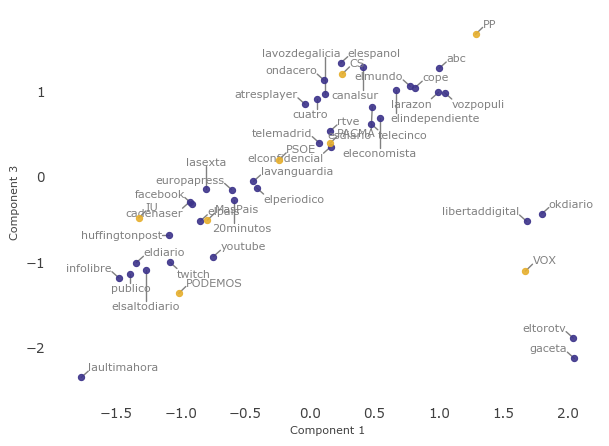

In [4]:
## Make plot.
# Dim 1: Left vs right 
# Dim 3: Far from norm vs conservative


plt.figure(figsize=(7,5))
model_norm = run_decom(df_norm.T, type_="pca")

X = model_norm.column_coordinates_[0]
print(dict(zip(df_norm.T.columns, X)))


plot_pca(model_norm, df_norm.T, x_d=0, y_d=2, kind="columns", color=palette[0])

# model_norm = run_decom(df_norm, type_="pca")
plot_pca(model_norm, df_norm.T, x_d=0, y_d=2, kind="rows", color=palette[1])




          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.494        54.11%                     54.11%
1              0.203        22.18%                     76.29%
2              0.082         9.01%                     85.30%
3              0.044         4.81%                     90.10%
4              0.036         3.98%                     94.08%


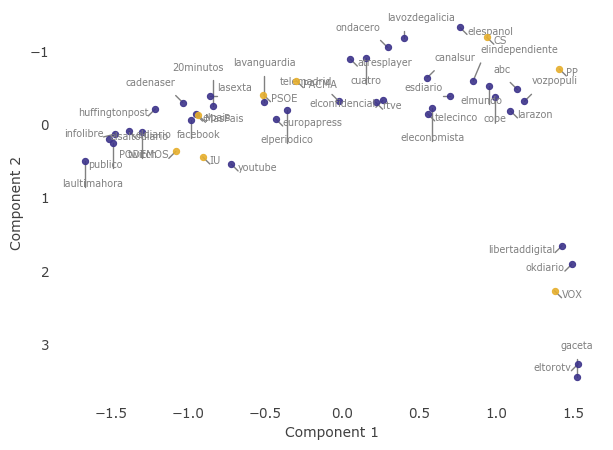

In [11]:
## Make plot.
# Dim 1: Left vs right 
# Dim 2: Far from norm vs conservative


plt.figure(figsize=(7, 5))

model_full = run_decom(df_full.T, type_="ca")
plot_pca(model_full, df_full.T, x_d=0, y_d=1, kind="columns", color=palette[0])

plot_pca(model_full, df_full.T, x_d=0, y_d=1, kind="rows", color=palette[1])


plt.gca().invert_yaxis()#for consistency


plt.savefig(path_figures+"twitter_ideolgoy.pdf", bbox_inches="tight")




In [13]:
X = model_full.column_coordinates(df_full.T)
print(X.to_dict())

{0: {'rtve': 0.38689642507767014, 'abc': 1.0556255774547407, 'elmundo': 0.9216822151460718, 'atresplayer': 0.2677484675039739, 'cope': 0.952508323800797, 'okdiario': 1.3135274405055521, 'larazon': 1.0232167619216739, 'ondacero': 0.4437883261745285, 'telecinco': 0.6326196165819746, 'vozpopuli': 1.0893794744754355, 'youtube': -0.29474299606340904, 'elespanol': 0.7850623676637538, 'europapress': -0.08430734821271865, 'elconfidencial': 0.4219609060987239, 'telemadrid': 0.21468494734061289, 'cuatro': 0.34341699332782794, 'canalsur': 0.6305394863891612, 'eltorotv': 1.344036115846531, 'elindependiente': 0.8470249162062684, 'cadenaser': -0.5225862946092766, 'eleconomista': 0.654682470974202, 'elpais': -0.4623159636827722, 'lavanguardia': -0.13756625801646072, 'esdiario': 0.7366953433673964, 'libertaddigital': 1.2673283041540073, '20minutos': -0.3780560524810071, 'elperiodico': -0.029055025171349596, 'lasexta': -0.3945199689410444, 'lavozdegalicia': 0.5203767340940603, 'eldiario': -0.7767191737

Text(23.541666666666664, 0, 'PCA')

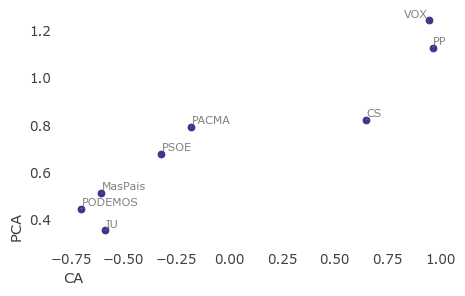

In [144]:
X = model_full.row_coordinates(df_full.T)[0]
Y = model_norm.row_coordinates(df_norm.T)[0]
plot_annotated_scatter(df_full.columns, X, Y)
plt.xlabel("CA")
plt.ylabel("PCA")

Text(15.041666666666666, 0, 'PCA')

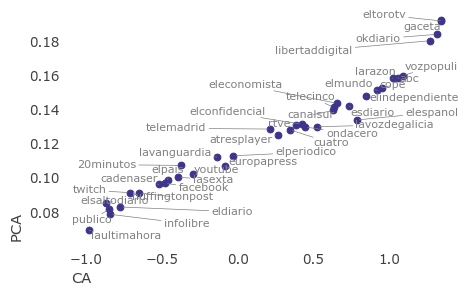

In [146]:
X = model_full.column_coordinates(df_full.T)[0]
Y = model_norm.column_coordinates_[0]
plot_annotated_scatter(df_full.T.columns, X, Y)
plt.xlabel("CA")
plt.ylabel("PCA")

In [152]:
X.to_dict()


{'rtve': 0.3868964250776702,
 'abc': 1.0556255774547407,
 'elmundo': 0.921682215146072,
 'atresplayer': 0.2677484675039739,
 'cope': 0.952508323800797,
 'okdiario': 1.3135274405055524,
 'larazon': 1.0232167619216739,
 'ondacero': 0.4437883261745283,
 'telecinco': 0.6326196165819746,
 'vozpopuli': 1.0893794744754357,
 'youtube': -0.29474299606340904,
 'elespanol': 0.7850623676637541,
 'europapress': -0.08430734821271864,
 'elconfidencial': 0.4219609060987241,
 'telemadrid': 0.214684947340613,
 'cuatro': 0.34341699332782794,
 'canalsur': 0.6305394863891609,
 'eltorotv': 1.3440361158465317,
 'elindependiente': 0.8470249162062686,
 'cadenaser': -0.5225862946092765,
 'eleconomista': 0.6546824709742022,
 'elpais': -0.462315963682772,
 'lavanguardia': -0.13756625801646055,
 'esdiario': 0.7366953433673963,
 'libertaddigital': 1.2673283041540075,
 '20minutos': -0.37805605248100693,
 'elperiodico': -0.029055025171349398,
 'lasexta': -0.39451996894104424,
 'lavozdegalicia': 0.5203767340940603,
 '

In [20]:
# Read idelogoy from pollitical watch
df = pd.read_csv("media_ideology_politicalwatch/media_general_topics/Filtered_Sources.csv")
df = df[["domain", "bias"]]
df["domain"] = df["domain"].str.split(".").str[1]
ideology_media_watch = df.set_index("domain").to_dict()["bias"]




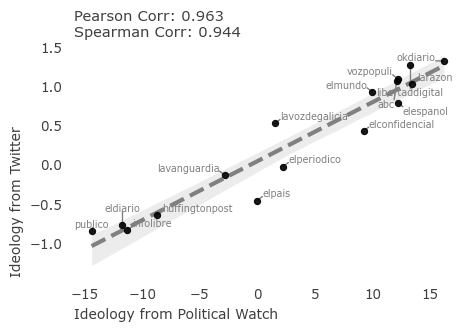

In [28]:
df = pd.concat([pd.DataFrame(ideology_media_watch, index=["media"]).T,
           pd.DataFrame(mn.domain_ideology_twitter, index=["twitter"]).T], axis=1).dropna()

mn.plot_annotated_scatter(df.index, df["media"], df["twitter"], show=False, adjust=True, default_color="darkgray", s=20, c="k", alpha=0.9, show_title=True, textsize=7, textcolor="gray")
# Add regression line
sns.regplot(x="media", y="twitter", data=df, scatter=False, color="gray", line_kws={"color":"gray", "linestyle":"--"})
# Add informative labels
plt.xlabel("Ideology from Political Watch", fontsize=10, ha="left")
plt.ylabel("Ideology from Twitter", fontsize=10, ha="left")
plt.savefig(path_figures+"twitter_media_ideology.pdf", bbox_inches="tight")

